In [ ]:
!pip install dgl
!pip install networkx

In [ ]:
import dgl
import networkx as nx
import numpy as np
import torch

In [ ]:
dataset = dgl.data.CiteseerGraphDataset()
dataset

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Dataset("citeseer", num_graphs=1, save_path=/root/.dgl/citeseer_d6836239)

In [ ]:
graph = dataset[0]
graph

Graph(num_nodes=3327, num_edges=9228,
      ndata_schemes={'feat': Scheme(shape=(3703,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [ ]:
graph_nx = dgl.to_networkx(graph, node_attrs=['label', 'feat'], edge_attrs=None)
graph_nx.nodes(data=True)

NodeDataView({0: {'label': tensor(3), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 1: {'label': tensor(1), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 2: {'label': tensor(5), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 3: {'label': tensor(5), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 4: {'label': tensor(3), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 5: {'label': tensor(1), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 6: {'label': tensor(3), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 7: {'label': tensor(0), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 8: {'label': tensor(3), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 9: {'label': tensor(5), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 10: {'label': tensor(2), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 11: {'label': tensor(4), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 12: {'label': tensor(2), 'feat': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 13: {'label': tensor(1), 'feat': t

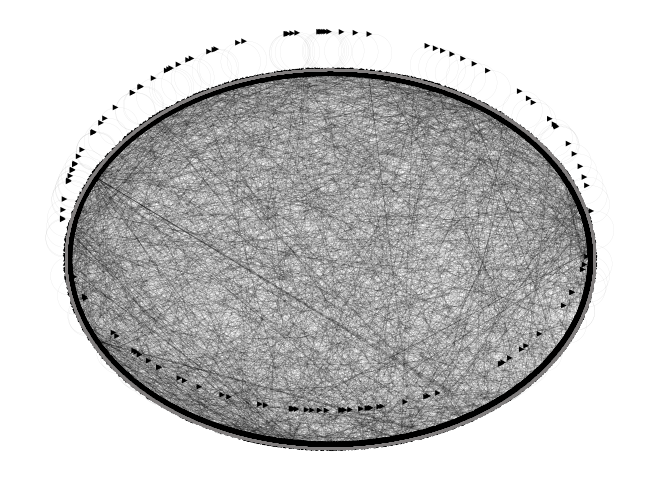

In [ ]:
import matplotlib.pyplot as plt

options = {'node_color':'red', 'node_size':1, 'width':0.02, 'edgecolors':'gray'}
nx.draw_circular(graph_nx, **options, with_labels=False)
# nx.draw_spring()
# nx.draw_networkx_nodes()
# nx.draw_networkx_edges()
plt.show()

In [ ]:
features = graph.ndata['feat']
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
adj = graph.adjacency_matrix()
print(type(adj))
print(adj)

<class 'dgl.sparse.sparse_matrix.SparseMatrix'>
SparseMatrix(indices=tensor([[   0,    1,    1,  ..., 3324, 3325, 3326],
                             [ 628,  158, 2919,  ..., 2820, 1643,   33]]),
             values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             shape=(3327, 3327), nnz=9228)


In [ ]:
adj_mx = adj.to_dense()
print(type(adj_mx))
print(adj_mx)

<class 'torch.Tensor'>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
a_size = graph.num_nodes()
a_size

3327

In [ ]:
adj_tilde = adj_mx + np.eye(a_size)
adj_tilde

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [ ]:
deg_tilde = torch.diag(torch.sum(adj_tilde, axis=0))
deg_tilde

tensor([[2., 0., 0.,  ..., 0., 0., 0.],
        [0., 6., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 4., 0., 0.],
        [0., 0., 0.,  ..., 0., 2., 0.],
        [0., 0., 0.,  ..., 0., 0., 2.]], dtype=torch.float64)

In [ ]:
adj_hat = torch.linalg.inv(deg_tilde)**(0.5) * adj_tilde * torch.linalg.inv(deg_tilde)**(0.5)

In [ ]:
n_input = features.shape[-1]
n_hidden = 32
n_embed = dataset.num_classes

In [ ]:
np.random.seed(100)

W_1 = np.random.normal(loc=0, scale=1, size=(n_input, n_hidden))
W_2 = np.random.normal(loc=0, scale=1, size=(n_hidden, n_embed))

In [ ]:
def gcn_layer(A_hat, X, W):
  return np.matmul(np.matmul(A_hat, X), W)

In [ ]:
import torch.nn.functional as func

H_1 = func.relu(gcn_layer(adj_hat, features, W_1))
H_2 = gcn_layer(adj_hat, H_1, W_2)

In [ ]:
H_2

tensor([[ 0.2531,  0.1939,  0.1070,  0.0453,  0.1019, -0.1190],
        [ 0.0233, -0.0154,  0.0246, -0.0202,  0.0046, -0.0108],
        [ 0.1602,  0.1658,  0.3831, -0.0276, -0.2383, -0.0637],
        ...,
        [ 0.0133,  0.0200,  0.0445,  0.0123, -0.0041, -0.0131],
        [ 0.0307,  0.3192,  0.1114, -0.0748,  0.0936, -0.0315],
        [ 0.1989,  0.0776,  0.0167, -0.0068, -0.0961,  0.1264]],
       dtype=torch.float64)